In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

In [2]:
dataOrg = pd.read_csv('Apartments_koopen.csv')

In [3]:
columnsToSelect = ['app', 'area', 'houseTypeValue', 'lotSize', 'price']
data = dataOrg.loc[:, columnsToSelect]

In [4]:
# Housenumber is not relevant, but street name and zip code might be relevant for our model:
import ast
def extract_street(location):
    street = ast.literal_eval(location)['street']
    return re.match('[^0-9]*', street).group()

def extract_zipcode(location):
    zipcode = ast.literal_eval(location)['zipcode']
    return zipcode

# lotSize column containts 'Onbekend', replace them with 0, and convert other data to integer values:
def correct_lotSize(x):
    if x == "Onbekend":
           x = int(0)
    else:
        x = int(x)
    return x

In [5]:
data.loc[:, 'street'] = dataOrg.location.apply(extract_street)
data.loc[:, 'zipcode'] = dataOrg.location.apply(extract_zipcode)
data.loc[:, 'lotSize'] = dataOrg.lotSize.apply(correct_lotSize)

# We're interested in price per squared meter:
data.loc[:, 'PricePA'] = data.price/data.area

# Street is already contained in zipcode. We do not want to introduce collinearity:
data = data.drop(columns = ['street', 'area', 'price'])



In [6]:
z = data.zipcode[1]
print(z)

1035PM


In [7]:
z[0:4] + ' ' + z[4:]

'1035 PM'

In [8]:
data.to_csv('HousingAmsterdam.csv', sep = ',')

In [9]:
data.head()

,app,houseTypeValue,lotSize,zipcode,PricePA
0,False,Herenhuis,91,1019WX,4948.113208
1,False,Vrijstaande woning,1470,1035PM,4619.205298
2,False,Eengezinswoning,265,1026CG,6796.116505
3,False,Tussenwoning,167,1025MS,3593.866667
4,False,Tussenwoning,90,1054DV,5789.473684


In [10]:
# Check how many properties there are per zip code:
t = data.pivot_table(index = 'zipcode', values = 'PricePA', aggfunc = 'count')
t.columns = ['total_count']
t

,total_count
zipcode,
1012EX,86
1013JK,86
1013ZM,86
1015HG,86
1019WX,86
1025MS,86
1026CG,86
1028AZ,86
1033KS,86


We can see that there are, in all cases, exactly 89 properties per zipcode (as Rafael said). This is very unusual, the possibility that the properties are so evenly distributed across zipcodes is very unlikely. I have to admit that I do not have any idea on why this is so, but I think it is important to think about it. I'd suggest we re-trace our steps, and see whether we did something wrong in the process of gathering the data.

# Linear Model

## Simple Linear Regression

In [11]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
# make copy, cos' you never know:
df = data.copy()

In [13]:
# Make dummies:
df = pd.get_dummies(df, columns = ['app', 'houseTypeValue', 'zipcode'])

In [14]:
# Avoid dummy variable trap:
df.drop(columns = ['app_False', 'houseTypeValue_Penthouse', 'zipcode_1068MS'], inplace = True)

In [15]:
df.head()

,lotSize,PricePA,app_True,houseTypeValue_Appartement,houseTypeValue_Bovenwoning,houseTypeValue_Bungalow,houseTypeValue_Eengezinswoning,houseTypeValue_Herenhuis,houseTypeValue_Tussenwoning,houseTypeValue_Vrijstaande woning,...,zipcode_1067SJ,zipcode_1068MZ,zipcode_1071BE,zipcode_1072BK,zipcode_1072ER,zipcode_1083TP,zipcode_1087BB,zipcode_1091BD,zipcode_1091CZ,zipcode_1098NA
0,91,4948.113208,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1470,4619.205298,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,265,6796.116505,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,167,3593.866667,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,90,5789.473684,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Create model matrix and response variable:
X = df.drop(columns = ['PricePA']).copy()
y = df.PricePA.copy()

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7)

In [18]:
# Building a regressor
regressor = linear_model.LinearRegression()

In [19]:
# Fitting the model
model = regressor.fit(X_train, y_train)

In [20]:
# Making prediction:
y_pred = model.predict(X_test)

In [21]:
pd.DataFrame(data = {'pred':y_pred, 'test':y_test}).head()

,pred,test
2508,5373.831776,5373.831776
1916,5555.555556,5555.555556
1397,5444.444444,5444.444444
1355,6357.142857,6357.142857
832,3166.666667,3166.666667


This accuracy is extremely weird. The model is impossibly accurate. Next, I will try lasso and see how it compares to this.

## Lasso Regression with cross-validation

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [23]:
regressor2 = linear_model.LassoCV(alphas = np.arange(0.01, 10, 0.1), normalize = True, n_jobs = -1, max_iter=10000, cv=10)

In [24]:
modelLasso = regressor2.fit(X_train, y_train)

In [25]:
y_pred_lasso = modelLasso.predict(X_test)

In [26]:
np.sum(y_pred_lasso-y_test)

-121.76528207671845

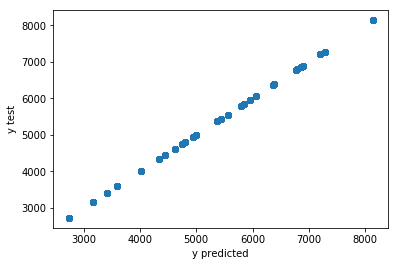

R^2 of the method is 1.00


In [27]:
plt.scatter(y_pred_lasso, y_test)
plt.xlabel('y predicted')
plt.ylabel('y test')
plt.show()
print('R^2 of the method is {0:.2f}'.format(r2_score(y_test, y_pred_lasso)))

In [28]:
pd.DataFrame({'variables':X.columns, 'coeffitients':modelLasso.coef_})

,variables,coeffitients
0,lotSize,-0.106983
1,app_True,1005.385542
2,houseTypeValue_Appartement,-0.000000
3,houseTypeValue_Bovenwoning,57.934058
4,houseTypeValue_Bungalow,2078.023826
5,houseTypeValue_Eengezinswoning,-1344.074284
6,houseTypeValue_Herenhuis,181.173973
7,houseTypeValue_Tussenwoning,-0.000000
8,houseTypeValue_Vrijstaande woning,-0.000000
9,houseTypeValue_Woning,-2031.238564
